In [1]:
import json
import logging
import pandas as pd 
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon

from tqdm import tqdm
from pathlib import Path
from Questionnaire.IPIPtest import IPIPTest

logging.basicConfig(level=logging.WARNING)

In [3]:
config_path: str = "configs/conf_GPT.json"
config = json.load(open(config_path, "r"))
config = config["model"]

In [ ]:
langs: str = ["DE", "EN", "JA", "MN", "ZH"]
excel_dir: str = "IPIP/"

results = {}

for lang in langs:

    excel_path = f"{excel_dir}/{lang}.xlsx"
    multi_list = pd.read_excel(excel_path)
    instuments = multi_list['instrument'].unique()

    results[lang] = {}

    for instrument in tqdm(instuments):
        
        save_path = f"output/{config['template_type']}/{lang}/{instrument}.jsonl"
        if not Path(save_path).exists():
            print(f"File {save_path} do not exists, skipping.")
            continue
        
        qn = IPIPTest(multi_list, instrument)
        qn.load_from_jsonl(save_path)

        results[lang][instrument] = qn.analyze()

    df = pd.DataFrame(results).T

    data = np.ma.masked_invalid(df.values.astype(float))  # 用 mask 处理 NaN
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(data, aspect='auto', interpolation='none')
    fig.colorbar(im, label='score')

    ax.set_xticks(range(df.shape[1]))
    ax.set_xticklabels(df.columns, rotation=45, ha='right')
    ax.set_yticks(range(df.shape[0]))
    ax.set_yticklabels(df.index)
    ax.set_title(f"Experiment Scores ({lang})")
    ax.tick_params(axis='x', labelsize=8)   # 减小字号
    plt.subplots_adjust(bottom=0.25)        # 给 x 轴标签留更多空间
    plt.tight_layout(); plt.show()

    save_path = f"output/{config['template_type']}/{lang}/experiment_scores.png"
    fig.savefig(save_path, bbox_inches='tight')
    df.to_csv(f"output/{config['template_type']}/{lang}/experiment_scores.csv", index=True)

/tmp/ipykernel_2807699/4122539676.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


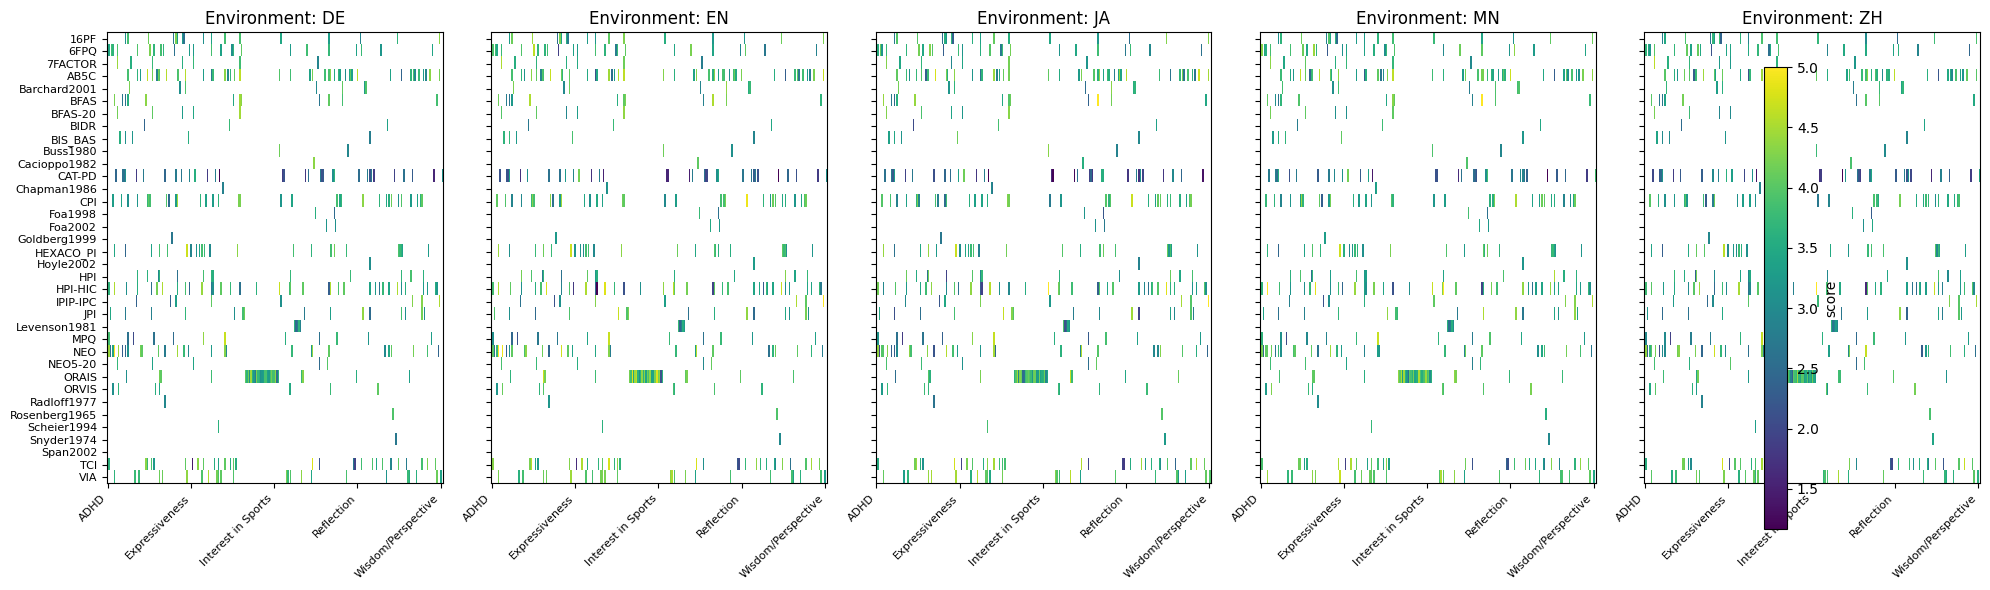

In [22]:

dfs = {
    env: pd.DataFrame(result).T
    for env, result in results.items()
}
panel = pd.concat(dfs, names=['env','experiment'])
panel = panel.reindex(sorted(panel.columns), axis=1)

envs = panel.index.get_level_values('env').unique()
n = len(envs)
fig, axes = plt.subplots(1, n, figsize=(4*n, 6), sharey=True)

for ax, env in zip(axes, envs):
    df_env = panel.loc[env]
    data = np.ma.masked_invalid(df_env.values.astype(float))
    im = ax.imshow(data, aspect='auto', interpolation='none')
    ax.set_title(f'Environment: {env}')
    
    n_dim = df_env.shape[1]
    max_labels = 4
    step = max(1, n_dim // max_labels)
    xticks = np.arange(n_dim)[::step]
    ax.set_xticks(xticks)
    ax.set_xticklabels(df_env.columns[::step], rotation=45, ha='right', fontsize=8)
    
    ax.set_yticks(np.arange(df_env.shape[0]))
    ax.set_yticklabels(df_env.index, fontsize=8)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label='score', fraction=0.02)
plt.tight_layout()
plt.show()

In [14]:
# Significance test

rows = []
for env, exps in results.items():
    for exp, dims in exps.items():
        for dim, val in dims.items():
            rows.append({'env': env, 'exp': exp, 'dim': dim, 'val': val})
df = pd.DataFrame(rows)

df_wide = df.pivot_table(index=['exp','dim'], columns='env', values='val')

df_common = df_wide.dropna(subset=langs)

for env in langs:
    x = df_common['EN']
    y = df_common[env]
    t_stat, t_p = ttest_rel(x, y)
    w_stat, w_p = wilcoxon(x, y)
    print(f"{env} vs EN: paired t-test p={t_p:.3f}, wilcoxon p={w_p:.3f}")

DE vs EN: paired t-test p=0.000, wilcoxon p=0.000
EN vs EN: paired t-test p=nan, wilcoxon p=nan
JA vs EN: paired t-test p=0.365, wilcoxon p=0.221
MN vs EN: paired t-test p=0.370, wilcoxon p=0.141
ZH vs EN: paired t-test p=0.000, wilcoxon p=0.000


/home/youyuan/miniconda3/envs/EMO_CTRL/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
